# Calculate location colours
The colours for locations are calcuated and stored as a YAML file.

## Imports

In [1]:
from ag3 import release_data
ag3_data = release_data()

In [2]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import allel

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
import cartopy.crs as ccrs
import matplotlib.cm as cm

## Settings

In [5]:
# https://matplotlib.org/examples/color/colormaps_reference.html
colour_map = 'nipy_spectral' 

output_path = '../data/location_colours.yml'

## Show the specified colour map

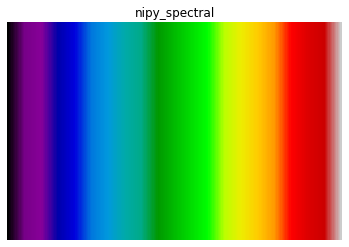

In [6]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.set_title(colour_map)
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(colour_map))
ax.set_axis_off()
plt.show()

## Get the locations of all of the wild samples

In [7]:
wild_sample_meta = ag3_data.load_sample_set_metadata(ag3_data.all_wild_sample_sets)
wild_sample_meta.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [8]:
# We only need the unique locations
locations = wild_sample_meta[['country', 'location', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
locations

,country,location,latitude,longitude
0,Angola,Luanda,-8.884,13.302
1,Burkina Faso,Pala,11.150,-4.235
2,Burkina Faso,Bana,11.233,-4.472
3,Burkina Faso,Souroukoudinga,11.235,-4.535
4,Burkina Faso,Monomtenga,12.060,-1.170
...,...,...,...,...
121,Tanzania,Moshi,-3.482,37.308
122,Tanzania,Tarime,-1.431,34.199
123,Tanzania,Muheza,-4.940,38.948
124,Uganda,Nagongera,0.770,34.026


In [9]:
# Compose a human-readable single-field label for each location
# Needs to be YAML-key compatible
locations["location_label"] = locations["country"] + '_' + locations["location"]
locations

,country,location,latitude,longitude,location_label
0,Angola,Luanda,-8.884,13.302,Angola_Luanda
1,Burkina Faso,Pala,11.150,-4.235,Burkina Faso_Pala
2,Burkina Faso,Bana,11.233,-4.472,Burkina Faso_Bana
3,Burkina Faso,Souroukoudinga,11.235,-4.535,Burkina Faso_Souroukoudinga
4,Burkina Faso,Monomtenga,12.060,-1.170,Burkina Faso_Monomtenga
...,...,...,...,...,...
121,Tanzania,Moshi,-3.482,37.308,Tanzania_Moshi
122,Tanzania,Tarime,-1.431,34.199,Tanzania_Tarime
123,Tanzania,Muheza,-4.940,38.948,Tanzania_Muheza
124,Uganda,Nagongera,0.770,34.026,Uganda_Nagongera


## Calculate the location colours

In [10]:
# Define a function to reduce all of the lat-longs (2D) to a single dimension (values 0 to 1) using PCA. 
def reduce_geographical_dimensionality(latitudes, longitudes):
    
    # TODO: add comments to explain these steps
    
    X_features = np.hstack([latitudes.reshape((-1, 1)), longitudes.reshape((-1, 1))])
    assert X_features.shape[1] == 2

    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)

    pca = PCA()
    pca.fit_transform(X_features)
    pca_variance = pca.explained_variance_

    coordinates = pca.transform(X_features)
    xv = coordinates[:, 0]
    yv = coordinates[:, 1]
    
    xv_for_map_col = (xv - xv.min())/(xv.max() - xv.min())
    return xv_for_map_col

In [11]:
locations["xv"] = reduce_geographical_dimensionality(locations.latitude.values, locations.longitude.values)
locations

,country,location,latitude,longitude,location_label,xv
0,Angola,Luanda,-8.884,13.302,Angola_Luanda,0.589528
1,Burkina Faso,Pala,11.150,-4.235,Burkina Faso_Pala,0.130406
2,Burkina Faso,Bana,11.233,-4.472,Burkina Faso_Bana,0.127217
3,Burkina Faso,Souroukoudinga,11.235,-4.535,Burkina Faso_Souroukoudinga,0.126692
4,Burkina Faso,Monomtenga,12.060,-1.170,Burkina Faso_Monomtenga,0.139783
...,...,...,...,...,...,...
121,Tanzania,Moshi,-3.482,37.308,Tanzania_Moshi,0.690685
122,Tanzania,Tarime,-1.431,34.199,Tanzania_Tarime,0.633398
123,Tanzania,Muheza,-4.940,38.948,Tanzania_Muheza,0.726946
124,Uganda,Nagongera,0.770,34.026,Uganda_Nagongera,0.596687


## Check the location colours on a map

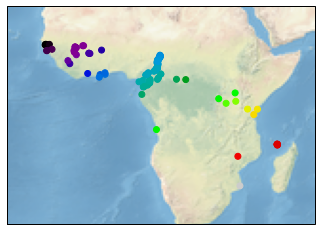

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

xlim = ([locations["longitude"].min() - 10,  locations["longitude"].max() + 10])
ylim = ([locations["latitude"].min() - 10,  locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.scatter(locations["longitude"], locations["latitude"], c=locations["xv"], cmap=colour_map)

plt.show()

## Record the RGBA tuple for each xv for this colour map

In [13]:
locations["RGBA"] = locations["xv"].apply(cm.get_cmap(colour_map))
locations["RGBA"][0]

(0.0, 0.968635294117647, 0.0, 1.0)

## Store the location colours as a file

In [14]:
# Get the location_labels and their corresponding RGBA cmap colours
location_colours = locations[['location_label', 'RGBA']].set_index('location_label')
location_colours

,RGBA
location_label,
Angola_Luanda,"(0.0, 0.968635294117647, 0.0, 1.0)"
Burkina Faso_Pala,"(0.2195941176470591, 0.0, 0.639235294117647, 1.0)"
Burkina Faso_Bana,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)"
Burkina Faso_Souroukoudinga,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)"
Burkina Faso_Monomtenga,"(0.13593921568627448, 0.0, 0.6496980392156863,..."
...,...
Tanzania_Moshi,"(0.8940843137254902, 0.9463784313725491, 0.0, ..."
Tanzania_Tarime,"(0.5176235294117647, 1.0, 0.0, 1.0)"
Tanzania_Muheza,"(0.972535294117647, 0.8548882352941177, 0.0, 1.0)"


In [15]:
# Convert the DataFrame values into a dictionary
location_colours_as_dict = location_colours.to_dict('index')

In [16]:
# Write the dictionary to YAML
with open(output_path, 'w') as ymlfile:
    tmp = yaml.dump(location_colours_as_dict, ymlfile, sort_keys=True)

## Check the location colours file

In [17]:
# Load the data from the YAML file
with open(output_path) as file:
    reloaded_data_dict = yaml.load(file, Loader=yaml.Loader)

In [18]:
# Convert the dict into a DataFrame
reloaded_df = pd.DataFrame.from_dict(reloaded_data_dict, orient='index')
reloaded_df.index.name = 'location_label'
reloaded_df

,RGBA
location_label,
Angola_Luanda,"(0.0, 0.968635294117647, 0.0, 1.0)"
Burkina Faso_Bana,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)"
Burkina Faso_Monomtenga,"(0.13593921568627448, 0.0, 0.6496980392156863,..."
Burkina Faso_Pala,"(0.2195941176470591, 0.0, 0.639235294117647, 1.0)"
Burkina Faso_Souroukoudinga,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)"
...,...
Tanzania_Muheza,"(0.972535294117647, 0.8548882352941177, 0.0, 1.0)"
Tanzania_Muleba,"(0.34508235294117645, 1.0, 0.0, 1.0)"
Tanzania_Tarime,"(0.5176235294117647, 1.0, 0.0, 1.0)"


In [19]:
# Match the location labels with the lat longs we have
original_locations = locations[['location_label', 'longitude', 'latitude']]
recovered_locations = reloaded_df.merge(original_locations, on='location_label')
recovered_locations

,location_label,RGBA,longitude,latitude
0,Angola_Luanda,"(0.0, 0.968635294117647, 0.0, 1.0)",13.302,-8.884
1,Burkina Faso_Bana,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)",-4.472,11.233
2,Burkina Faso_Monomtenga,"(0.13593921568627448, 0.0, 0.6496980392156863,...",-1.170,12.060
3,Burkina Faso_Pala,"(0.2195941176470591, 0.0, 0.639235294117647, 1.0)",-4.235,11.150
4,Burkina Faso_Souroukoudinga,"(0.261421568627451, 0.0, 0.6340039215686274, 1.0)",-4.535,11.235
...,...,...,...,...
121,Tanzania_Muheza,"(0.972535294117647, 0.8548882352941177, 0.0, 1.0)",38.948,-4.940
122,Tanzania_Muleba,"(0.34508235294117645, 1.0, 0.0, 1.0)",31.651,-1.962
123,Tanzania_Tarime,"(0.5176235294117647, 1.0, 0.0, 1.0)",34.199,-1.431
124,Uganda_Kihihi,"(0.0, 0.968635294117647, 0.0, 1.0)",29.701,-0.751


### Eyeball the colours from the file on a map

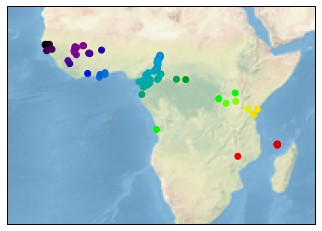

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

xlim = ([recovered_locations["longitude"].min() - 10,  recovered_locations["longitude"].max() + 10])
ylim = ([recovered_locations["latitude"].min() - 10,  recovered_locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.scatter(recovered_locations["longitude"], recovered_locations["latitude"], color=recovered_locations["RGBA"])

plt.show()